# Version 1.0

## Initial TensorFlow impelementations of Deep Learning methods

**Models designed**
- DNN
- LSTM
- GRU

**Adaptation to be made to improve performance:**

- Batch Normaliation Layers [PythonAlgos](https://pythonalgos.com/build-a-gru-rnn-in-keras/)
- Hyperparameter Tuning

# Imports

In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import DataLoader, TensorDataset

import lightning as L

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

# Utilities

In [145]:
target_col = 0

class WeatherDataModule(L.LightningDataModule):
    def __init__(self, data_dir="data\current_weather_data.csv", index_='timestamp', 
                 column=0, batch_size=64, window_size=5, normalize_=False,
                 date_range = None, step_ = 24):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.index_ = index_
        self.column = column
        self.date_range = date_range
        self.window_size = window_size
        self.step_ = step_

        self.normalize_ = normalize_

    def prepare_data(self):
        df_ = pd.read_csv(self.data_dir, index_col=self.index_, parse_dates=True)
        if self.date_range != None:
            df_ = df_[self.date_range]
        
        if self.column == None:
            self.df = df_
        else:
            self.df = df_.iloc[:,self.column]
        
        if self.normalize_:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.df.values.reshape(-1, 1))
            self.df = self.normalize(self.df)

        self.windows, self.targets = self.window_step(self.df, self.step_)
        self.windows, self.targets = self.windows.squeeze(), self.targets.squeeze()

    def window_step(self, dataset, step_ ):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-self.window_size - step_):
            feature = dataset[i:i+self.window_size]
            target = dataset[i+self.window_size:i+self.window_size+step_]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return np.array(X), np.array(y)
    
    def normalize(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.fit_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.fit_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_normalze(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.inverse_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_single_column(self, series):
        if self.column == None:
            zeros_ = pd.DataFrame(np.zeros((series.shape[0], self.df.shape[1])))
            zeros_[target_col] = series 
            return pd.DataFrame(self.scaler.inverse_transform(zeros_))[target_col]
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.reshape(-1, 1)))

    def setup(self, stage: str):
        self.split = [round(len(self.df) * 0.7), round(len(self.df) * 0.9)]

        self.f_train, self.t_train = self.windows[:self.split[0]], self.targets[:self.split[0]]
        self.f_valid, self.t_valid = self.windows[self.split[0]:self.split[1]], self.targets[self.split[0]:self.split[1]]
        self.f_test, self.t_test = self.windows[self.split[1]:], self.targets[self.split[1]:]

        print(f'Train: {self.f_train.shape}\nValid: {self.f_valid.shape}\nTest: {self.f_test.shape}')

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, adam_ = False):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.adam_ = adam_

        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        if self.adam_:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

class PyTorchMLP_UNI(torch.nn.Module):
    def __init__(self, num_features, hidden_size = [50, 25], num_classes = 1):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # # 1st hidden layer
            # torch.nn.Flatten(),
            torch.nn.Linear(num_features, hidden_size[0]),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(hidden_size[0], hidden_size[1]),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(hidden_size[1], num_classes),
        )

    def forward(self, x):
        # x = torch.flatten(x, start_dim=1)
        # x = x.to(torch.float32)
        logits = self.all_layers(x)
        return logits

def plot_results(seed, height, width, interval, X, y, dnn_model, lstm_model, gru_model, plot_features=True, metrics=True, window_size=24, step=1, dm=None):

    mse_dnn = []
    mse_lstm = []
    mse_gru = []
    mse_avg = []

    mse_tracker = {'Deep Neural Network': mse_dnn, 'LSTM': mse_lstm, 'GRU': mse_gru, 'Average': mse_avg}

    fig, axes = plt.subplots(height,width, figsize=(18, 3 * height))

    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            seed_index = i * 2 + j
            seed = seed_index * interval 
            current_data = X[seed:seed + 1]

            # current_data_ = current_data.reshape(1, window_size * dm.df.shape[1])

            step_pred_dnn = dnn_model.predict(current_data, verbose = 0).squeeze()
            step_pred_lstm = lstm_model.predict(current_data, verbose = 0).squeeze()
            step_pred_gru = gru_model.predict(current_data, verbose = 0).squeeze()

            average = (step_pred_dnn + step_pred_lstm + step_pred_gru) / 3

            if dm.column == None:
                t_test_data = y[seed:seed + step][0][:, target_col]
                current_data = current_data[:, target_col]
            else:
                t_test_data = y[seed]

            if plot_features:
                ax.plot(range(window_size), current_data[:, 0], label='temperature', c='gray')
                ax.plot(range(window_size), current_data[:, 1], label='humidity', c='gray')
                ax.plot(range(window_size), current_data[:, 3], label='wind_direction', c='gray')
                ax.plot(range(window_size), current_data[:, 4], label='wind_gusts', c='gray')

            if dm.normalize_: 
                ax.plot(range(window_size), dm.inverse_single_column(current_data), label='wind_speed', c='black')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(t_test_data), label = 'Target', c='blue')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_dnn), label = 'Reg', c='green')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_lstm), label = 'LSTM', c='red')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_gru), label = 'GRU', c='purple')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(average), label = 'Average', c='orange', linewidth=2)

                mse_dnn.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_dnn)))
                mse_lstm.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_lstm)))
                mse_gru.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_gru)))
                mse_avg.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(average)))

            else:
                ax.plot(range(window_size), current_data, label='wind_speed', c='black')
                ax.plot(range(window_size, window_size + step), t_test_data, label = 'Target', c='blue')
                ax.plot(range(window_size, window_size + step), step_pred_dnn, label = 'Reg', c='green')
                ax.plot(range(window_size, window_size + step), step_pred_lstm, label = 'LSTM', c='red')
                ax.plot(range(window_size, window_size + step), step_pred_gru, label = 'GRU', c='purple')
                ax.plot(range(window_size, window_size + step), average, label = 'Average', c='orange', linewidth=2)

                mse_dnn.append(mean_squared_error(t_test_data, step_pred_dnn))
                mse_lstm.append(mean_squared_error(t_test_data, step_pred_lstm))
                mse_gru.append(mean_squared_error(t_test_data, step_pred_gru))
                mse_avg.append(mean_squared_error(t_test_data, average))

            if i == 0 and j == 0:  
                ax.legend(loc='upper left')

            ax.set_title(f"Seed: {seed}")

    if metrics:
        for key, value in mse_tracker.items():
            print(f'Mean MSE for {key}: {np.mean(value)}')
        

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.bar(mse_tracker.keys(), [np.mean(value) for value in mse_tracker.values()])
    plt.xlabel('Models')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE for Different Models')
    plt.show()

    return [np.mean(value) for value in mse_tracker.values()]

def setup_data(train_ = False, uni = True, source = 'OM', window_size = 24*4, step = 24, sanity_check = False):
    if uni:
        column_ = 0
    else:
        column_ = None

    dm = WeatherDataModule(data_dir=f'data\Sere Wind Farm_hourly_{source}.csv', 
                        window_size=window_size, column=column_,
                        batch_size=32, step_=step, 
                        normalize_=True)

    dm.prepare_data()
    dm.setup('')

    if sanity_check:
        plt.plot(np.arange(window_size),dm.f_test[0], label='Input')
        if step == 1:
            plt.scatter(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', s=5, c='r')
        else:
            plt.plot(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', c='r')
        plt.legend()
        plt.show()

    return dm

def build_model(hidden_size = [64, 32], out = 1, input_shape_ = 24 * 2, type_ = 'DNN'):
    if type_ == 'DNN':
        model = Sequential()
        model.add(Dense(hidden_size[0], input_shape=(input_shape_,)))
        model.add(Dense(hidden_size[1], activation='relu'))
        model.add(Dense(out))
    elif type_ == 'LSTM':
        model = Sequential()
        model.add(LSTM(hidden_size[0], input_shape=(input_shape_, 1)))
        # model.add(Dense(hidden_size[1], activation='relu'))
        model.add(Dense(out))

    elif type_ == 'GRU':
        model = Sequential()
        model.add(GRU(hidden_size[0], input_shape=(input_shape_, 1)))
        # model.add(Dense(hidden_size[1], activation='relu'))
        model.add(Dense(out))

    return model

# Setup

In [110]:
window_size = 24*4
step = 24
source = 'OWM'

dm = setup_data(train_ = False, uni = True, source = source, window_size = window_size, step = step, sanity_check = False)

Train: (6050, 96)
Valid: (1729, 96)
Test: (744, 96)


# Train

In [143]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

'''AVAILABLE MODELS: DNN, LSTM, GRU'''
name = 'GRU'
model = build_model(hidden_size=[64, 32], out=step, input_shape_= window_size, type_=name)

checkpoint_path = f"deep_models/keras_model_{name}_ws_{window_size}_{step}_{source}.h5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

model.compile(optimizer='adam', loss='mse')

model.fit(dm.f_train, dm.t_train, validation_data=(dm.f_valid, dm.t_valid), epochs=150, batch_size=32, verbose=1, callbacks=[early_stop, checkpoint])

Epoch 1/150
190/190 [==============================] - 6s 24ms/step - loss: 0.0389 - val_loss: 0.0355
Epoch 2/150
  8/190 [>.............................] - ETA: 3s - loss: 0.0311

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - 5s 25ms/step - loss: 0.0261 - val_loss: 0.0195
Epoch 3/150
190/190 [==============================] - 6s 33ms/step - loss: 0.0230 - val_loss: 0.0187
Epoch 4/150
190/190 [==============================] - 6s 31ms/step - loss: 0.0226 - val_loss: 0.0202
Epoch 5/150
190/190 [==============================] - 5s 27ms/step - loss: 0.0225 - val_loss: 0.0195
Epoch 6/150
190/190 [==============================] - 5s 28ms/step - loss: 0.0221 - val_loss: 0.0177
Epoch 7/150
190/190 [==============================] - 6s 33ms/step - loss: 0.0219 - val_loss: 0.0181
Epoch 8/150
190/190 [==============================] - 5s 28ms/step - loss: 0.0218 - val_loss: 0.0174
Epoch 9/150
190/190 [==============================] - 5s 27ms/step - loss: 0.0216 - val_loss: 0.0174
Epoch 10/150
190/190 [==============================] - 5s 28ms/step - loss: 0.0215 - val_loss: 0.0174
Epoch 11/150
190/190 [==============================] - 5s 25ms/step - loss: 0.0215 - val_los

In [144]:
print('Validation Set:\t', model.evaluate(dm.f_valid, dm.t_valid, verbose=0))
print('Test Set: \t', model.evaluate(dm.f_test, dm.t_test, verbose=0))

Validation Set:	 0.0163526963442564
Test Set: 	 0.016558654606342316


# Test

In [152]:
# name, window_size, step, source = 'LSTM', 24*4, 24, 'OWM'
seed = 0
model_dnn= tf.keras.models.load_model(f"deep_models/keras_model_DNN_ws_{window_size}_{step}_{source}.h5")
model_lstm= tf.keras.models.load_model(f"deep_models/keras_model_LSTM_ws_{window_size}_{step}_{source}.h5")
model_gru= tf.keras.models.load_model(f"deep_models/keras_model_GRU_ws_{window_size}_{step}_{source}.h5")
# model_lstm= tf.keras.models.load_model("deep_models\keras_model_LSTM_ws_96_24_OWM_WITHDENSE.h5")


sanity = False

if sanity:
    seed += 1

    prediction_dnn = model_dnn.predict(dm.f_valid[seed:seed+1]).squeeze()
    prediction_lstm = model_lstm.predict(dm.f_valid[seed:seed+1]).squeeze()
    prediction_gru = model_gru.predict(dm.f_valid[seed:seed+1]).squeeze()

    plt.plot(np.arange(window_size), dm.f_valid[seed], label='Input')
    plt.plot(np.arange(window_size,window_size + step), prediction_dnn, label='DNN', c = 'r')
    plt.plot(np.arange(window_size,window_size + step), prediction_lstm, label='LSTM', c = 'b')
    plt.plot(np.arange(window_size,window_size + step), prediction_gru, label='GRU', c = 'black')
    plt.plot(np.arange(window_size,window_size + step), dm.t_valid[seed], label='True', c = 'g')
    plt.legend()
    plt.show()

    df = pd.read_csv(f'data\Sere Wind Farm_hourly_{source}.csv', index_col='timestamp', parse_dates=True)

    plt.plot(df.index[dm.split[0]:dm.split[0] + window_size + step], df[dm.split[0]:dm.split[0] + window_size + step]['wind_speed'])
    plt.legend(df.columns)
    plt.show()

Mean MSE for Deep Neural Network: 2.86666840897196
Mean MSE for LSTM: 2.5509121802411228
Mean MSE for GRU: 2.6316900278763664
Mean MSE for Average: 2.5446565763979


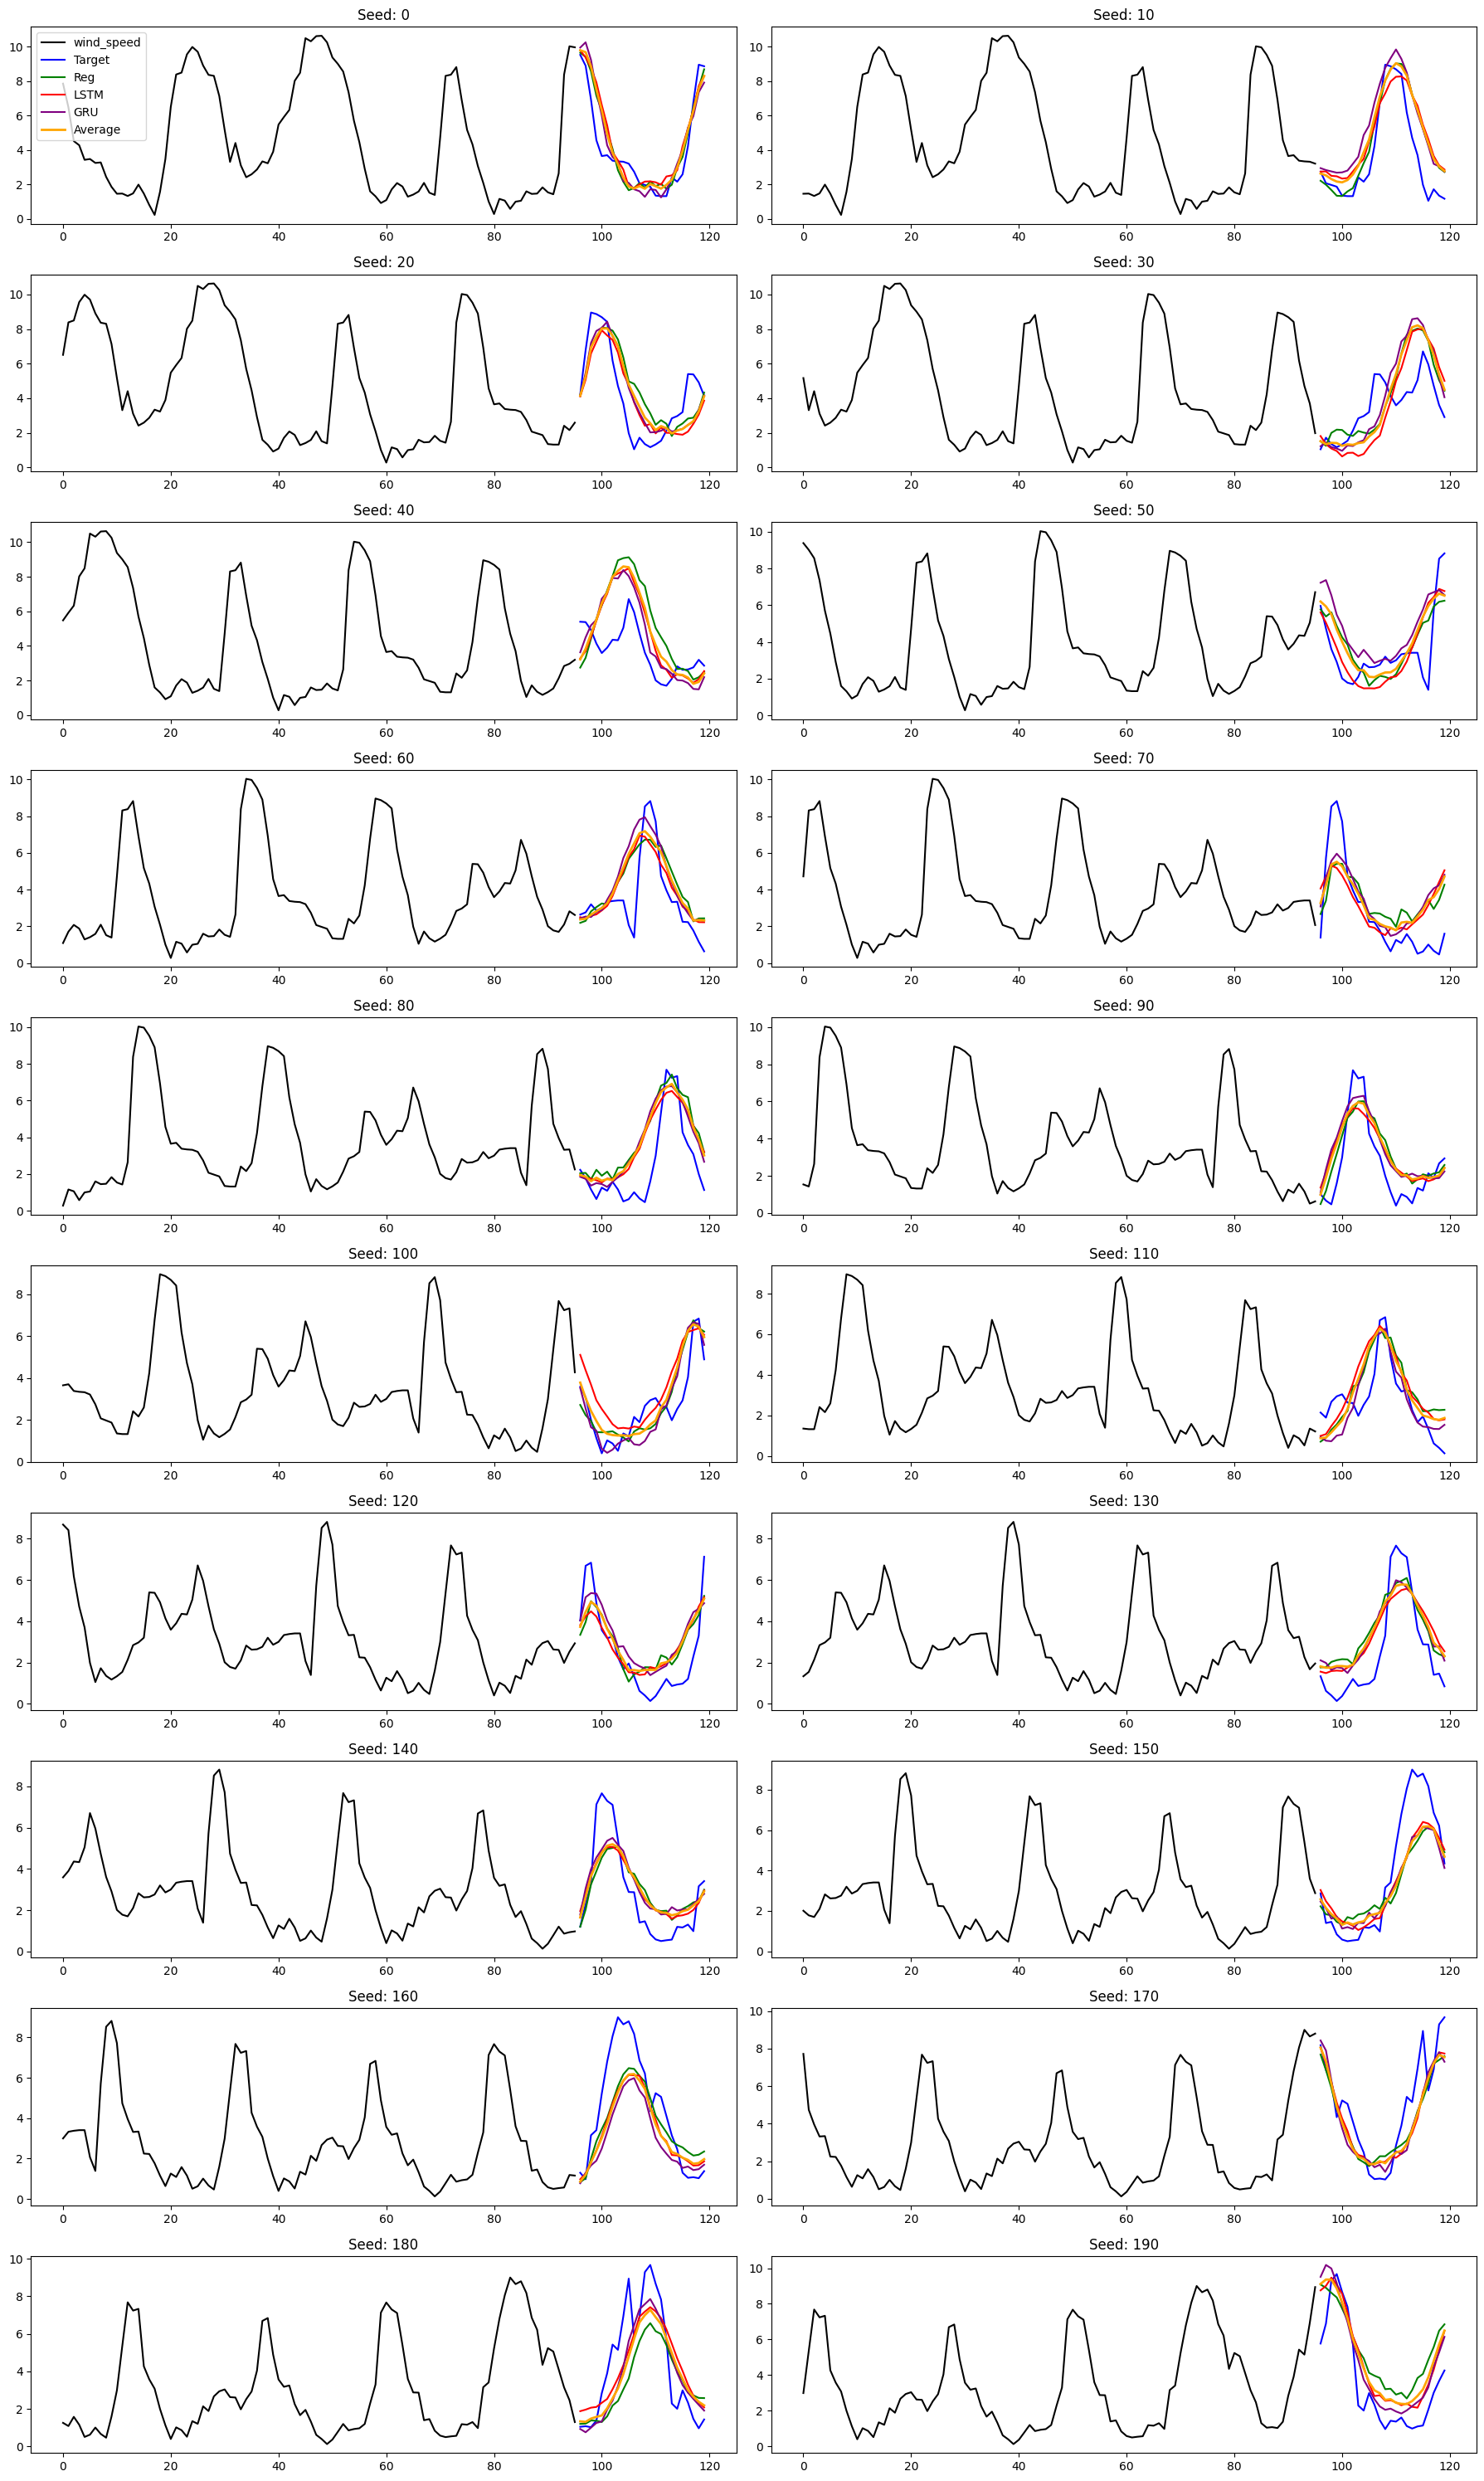

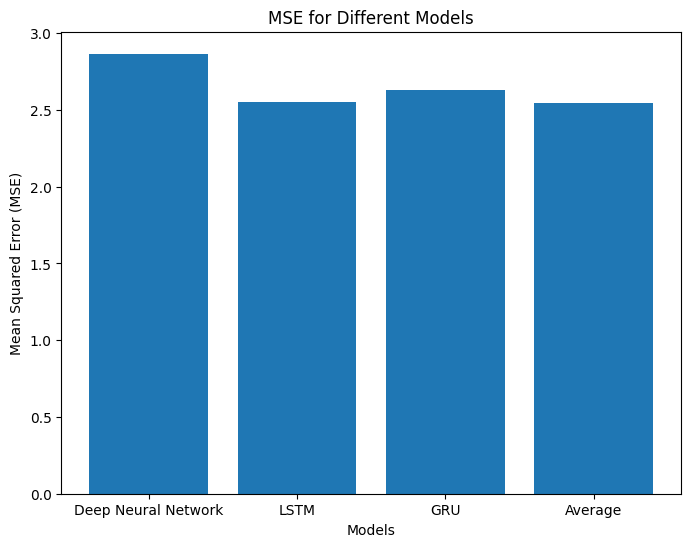

In [153]:
mse = plot_results(seed=0, height=10, width=2, interval=10, X=dm.f_test, y=dm.t_test, plot_features=False, 
                   window_size=window_size,step=step, dnn_model=model_dnn, lstm_model=model_lstm, gru_model=model_gru, dm=dm)